**CREDIT RELIABILITY FOR THE ISSUANCE OF THE CREDIT CARD**

The project consists of creating a model capable of estimating the creditworthiness of a customer, in order to help the dedicated team understand whether or not to accept the request for the issuance of the credit card. Two datasets are used. The first contains the customer's credit history month by month and on the basis of this they will be labeled as good or bad customer. The second dataset contains variables regarding the personal and financial characteristics of the customer.

**Import libraries**

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.stats import chi2_contingency
import scipy.stats as stats
from math import floor

**Import first dataset**

In [258]:
cr =pd.read_csv('/content/drive/MyDrive/credit_record.csv', index_col=0)
cr.head()

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001711,-1,0
5001711,-2,0
5001711,-3,0
5001712,0,C


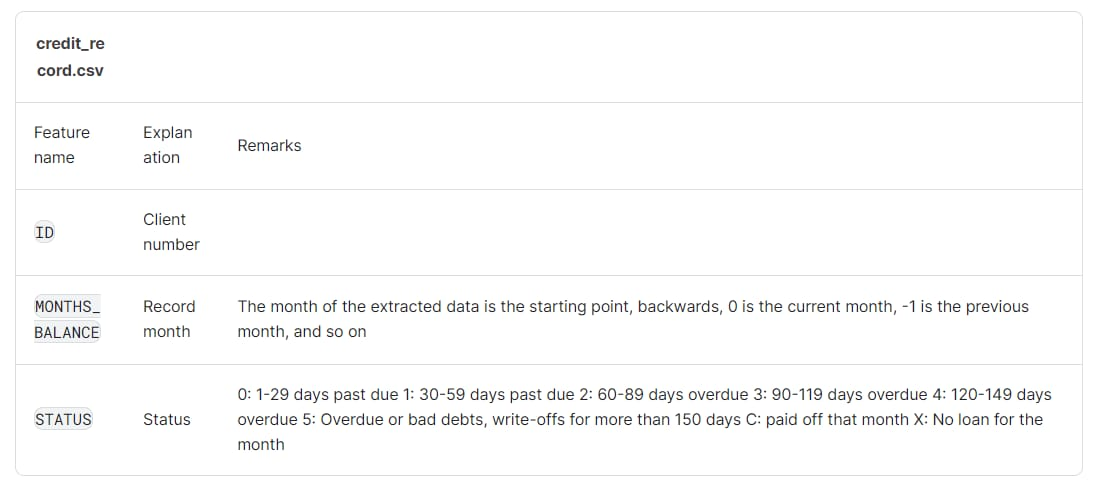

In [259]:
from IPython.display import Image
dataset1 = '/content/drive/MyDrive/dataset1.jpg'
Image(filename=dataset1)


**Creating the "Response" variable**

For each customer I calculated the number of months that make up the history of each customer. I only took into consideration those who have been customers for more than 6 months. I also changed the labels of "STATUS" starting from C which becomes 0, 0 becomes 1 and so on. Then I calculated the median on the credit statuses, leaving out the statuses marked with "X" because the customer did not benefit from any credit from the bank. Once calculated, I will label those who have a median less than 2 as good customers and those who have a median greater than or equal to 2 as bad customers because in this case the median corresponds to non-payment of debts for over two months.

In [260]:
cr_month = cr.groupby('ID')['MONTHS_BALANCE'].size().reset_index()
cr_month = cr_month.rename(columns={'MONTHS_BALANCE': 'NUMBER_MONTHS'})
cr_month.head()

,ID,NUMBER_MONTHS
0,5001711,4
1,5001712,19
2,5001713,22
3,5001714,15
4,5001715,60


In [261]:
cr = cr.loc[cr['STATUS'] != 'X']
cr.head()

status_map = {'C':0, '0':1, '1':2, '2':3, '3':4, '4':5, '5':6}
cr['STATUS'] = cr['STATUS'].map(status_map)
cr.head()

<ipython-input-261-d9e08dea9965>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr['STATUS'] = cr['STATUS'].map(status_map)


,MONTHS_BALANCE,STATUS
ID,,
5001711,-1,1
5001711,-2,1
5001711,-3,1
5001712,0,0
5001712,-1,0


In [262]:
cr = cr.groupby('ID')['STATUS'].median().reset_index()
cr = cr.rename(columns={'STATUS': 'MEDIAN_STATUS'})
cr.head()

,ID,MEDIAN_STATUS
0,5001711,1.0
1,5001712,1.0
2,5001717,1.0
3,5001718,1.0
4,5001719,0.0


In [263]:
cr = pd.merge(cr, cr_month, on='ID', how='inner')
cr.head()

,ID,MEDIAN_STATUS,NUMBER_MONTHS
0,5001711,1.0,4
1,5001712,1.0,19
2,5001717,1.0,22
3,5001718,1.0,39
4,5001719,0.0,43


In [264]:
cr = cr.loc[cr['NUMBER_MONTHS'] > 6]
cr.head()

,ID,MEDIAN_STATUS,NUMBER_MONTHS
1,5001712,1.0,19
2,5001717,1.0,22
3,5001718,1.0,39
4,5001719,0.0,43
5,5001720,1.0,36


In [265]:
cr['RESPONSE'] = cr['MEDIAN_STATUS'].apply(lambda x: 1 if x < 2 else 0)
cr.head()

<ipython-input-265-c276998d5d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cr['RESPONSE'] = cr['MEDIAN_STATUS'].apply(lambda x: 1 if x < 2 else 0)


,ID,MEDIAN_STATUS,NUMBER_MONTHS,RESPONSE
1,5001712,1.0,19,1
2,5001717,1.0,22,1
3,5001718,1.0,39,1
4,5001719,0.0,43,1
5,5001720,1.0,36,1


In [266]:
cr = cr.drop(cr[['MEDIAN_STATUS', 'NUMBER_MONTHS']],axis=1)
cr.head()

,ID,RESPONSE
1,5001712,1
2,5001717,1
3,5001718,1
4,5001719,1
5,5001720,1


In [267]:
cr['RESPONSE'].value_counts()

1    35404
0      179
Name: RESPONSE, dtype: int64

**Import second dataset**

I imported the second dataset and performed a "join" with the new previously calculated dataset. This way I will have the "Response" variable for each ID.

In [268]:
df = pd.read_csv('/content/drive/MyDrive/application_record.csv')
print(df.shape)
df.head()

(438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


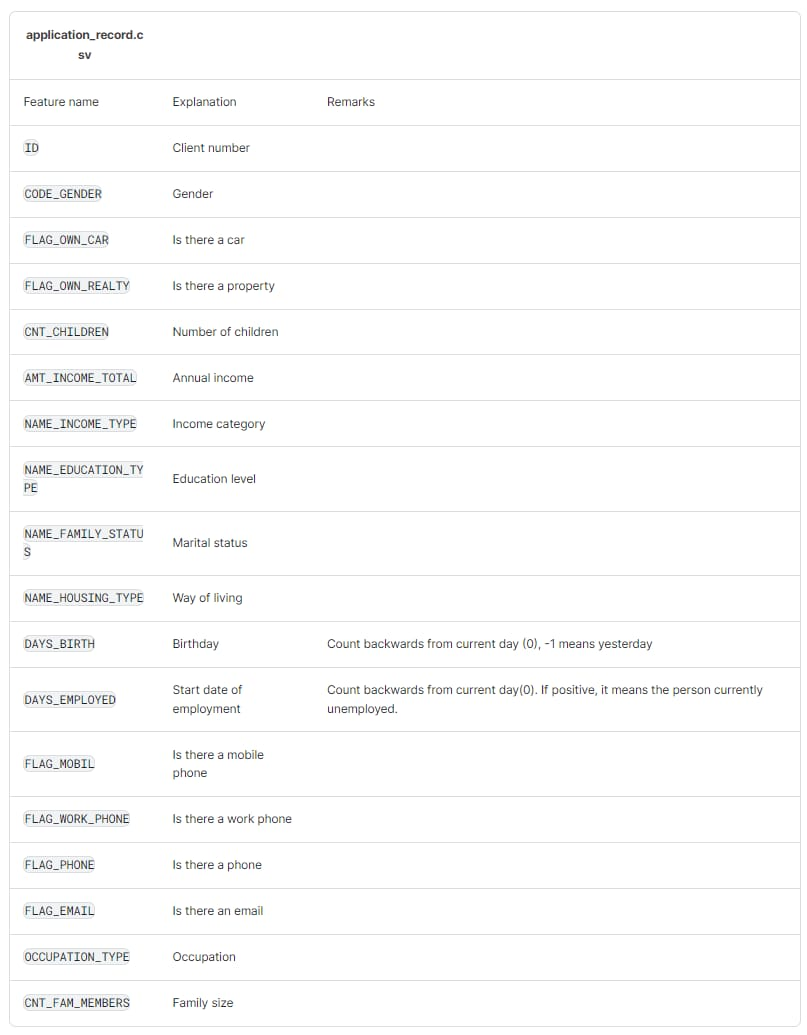

In [269]:
dataset2 = '/content/drive/MyDrive/dataset2.jpg'
Image(filename=dataset2)


In [270]:
df = pd.merge(df, cr, on='ID', how='inner')
print(df.shape)
df.head()

(27873, 19)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,RESPONSE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


**Exploratory Data Analysis & Feature Selection**

To decide which variables to include in the model I will use a test to verify the presence or otherwise of a relationship between the quantitative variables and the target variable "RESPONSE". The chi-square test
will be used for qualitative variables.

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27873 entries, 0 to 27872
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   27873 non-null  int64  
 1   CODE_GENDER          27873 non-null  object 
 2   FLAG_OWN_CAR         27873 non-null  object 
 3   FLAG_OWN_REALTY      27873 non-null  object 
 4   CNT_CHILDREN         27873 non-null  int64  
 5   AMT_INCOME_TOTAL     27873 non-null  float64
 6   NAME_INCOME_TYPE     27873 non-null  object 
 7   NAME_EDUCATION_TYPE  27873 non-null  object 
 8   NAME_FAMILY_STATUS   27873 non-null  object 
 9   NAME_HOUSING_TYPE    27873 non-null  object 
 10  DAYS_BIRTH           27873 non-null  int64  
 11  DAYS_EMPLOYED        27873 non-null  int64  
 12  FLAG_MOBIL           27873 non-null  int64  
 13  FLAG_WORK_PHONE      27873 non-null  int64  
 14  FLAG_PHONE           27873 non-null  int64  
 15  FLAG_EMAIL           27873 non-null 

In [272]:
X_cont = df[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']]

In [273]:
for i in X_cont:
  print(f't test between {i} and RESPONSE')
  group1=df[i]
  group2=df['RESPONSE']
  t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False)
  # Stampa i risultati
  print(f"T Statistic: {t_statistic}")
  print(f"P Value: {p_value}")
  # Interpretazione dei risultati
  if p_value < 0.05:
    print("Reject null hypothesis: there is a difference in mean between the groups.")
  else:
    print("Fail to reject null hypothesis: there isn't a difference in mean between the groups.")
  print("-----")
  print("-----")

t test between CNT_CHILDREN and RESPONSE
T Statistic: -127.90698890679579
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
-----
t test between AMT_INCOME_TOTAL and RESPONSE
T Statistic: 303.71506962880864
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
-----
t test between DAYS_BIRTH and RESPONSE
T Statistic: -642.0712679011307
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
-----
t test between DAYS_EMPLOYED and RESPONSE
T Statistic: 71.27347256588882
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
-----
t test between CNT_FAM_MEMBERS and RESPONSE
T Statistic: 222.6235708623585
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
-----


In [274]:
X_cat = df[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','RESPONSE']]

In [275]:
for i in X_cat:
  print(f'chi2 test between {i} and RESPONSE')
  contingency_table = pd.crosstab(X_cat['RESPONSE'], X_cat[i])
  chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
  print(f'p-value: {p_val}')
  if p_val < 0.05:
    print('There is a dependency between the variables.')
  else:
    print('There is no dependency between the variables.')
  print('----------')
  print('----------')

chi2 test between CODE_GENDER and RESPONSE
p-value: 2.2305232967689537e-05
There is a dependency between the variables.
----------
----------
chi2 test between FLAG_OWN_CAR and RESPONSE
p-value: 0.22331805433620538
There is no dependency between the variables.
----------
----------
chi2 test between FLAG_OWN_REALTY and RESPONSE
p-value: 0.004726230835363753
There is a dependency between the variables.
----------
----------
chi2 test between NAME_INCOME_TYPE and RESPONSE
p-value: 0.005859609779926681
There is a dependency between the variables.
----------
----------
chi2 test between NAME_EDUCATION_TYPE and RESPONSE
p-value: 0.0274443987749991
There is a dependency between the variables.
----------
----------
chi2 test between NAME_FAMILY_STATUS and RESPONSE
p-value: 0.18645498147245113
There is no dependency between the variables.
----------
----------
chi2 test between NAME_HOUSING_TYPE and RESPONSE
p-value: 0.010118848951668064
There is a dependency between the variables.
----------


On the basis of the test results I decided not to include in the model all those variables linked to the use of commonly used tools such as cars, phones and mails, which do not discriminate good clients from bad ones

**Data preprocessing**

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27873 entries, 0 to 27872
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   27873 non-null  int64  
 1   CODE_GENDER          27873 non-null  object 
 2   FLAG_OWN_CAR         27873 non-null  object 
 3   FLAG_OWN_REALTY      27873 non-null  object 
 4   CNT_CHILDREN         27873 non-null  int64  
 5   AMT_INCOME_TOTAL     27873 non-null  float64
 6   NAME_INCOME_TYPE     27873 non-null  object 
 7   NAME_EDUCATION_TYPE  27873 non-null  object 
 8   NAME_FAMILY_STATUS   27873 non-null  object 
 9   NAME_HOUSING_TYPE    27873 non-null  object 
 10  DAYS_BIRTH           27873 non-null  int64  
 11  DAYS_EMPLOYED        27873 non-null  int64  
 12  FLAG_MOBIL           27873 non-null  int64  
 13  FLAG_WORK_PHONE      27873 non-null  int64  
 14  FLAG_PHONE           27873 non-null  int64  
 15  FLAG_EMAIL           27873 non-null 

----------

Missing values

In [277]:
df['OCCUPATION_TYPE'].isna().sum()

8625

The variable "OCCUPATION_TYPE" has 8625 missing values. When I will transform this variable into a dummy all the observations with missing values ​​will all have 0 corresponding to the "OCCUPATION_TYPE_..." modes representing the baseline category.

----------

Encoding

In [278]:
print(df['CODE_GENDER'].value_counts())
map_gen = {'M':1, 'F':0}
df['CODE_GENDER'] = df['CODE_GENDER'].map(map_gen)

F    18617
M     9256
Name: CODE_GENDER, dtype: int64


In [279]:
print(df['FLAG_OWN_CAR'].value_counts())
map_gen = {'Y':1, 'N':0}
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map(map_gen)

N    17100
Y    10773
Name: FLAG_OWN_CAR, dtype: int64


In [280]:
print(df['FLAG_OWN_REALTY'].value_counts())
map_gen = {'Y':1, 'N':0}
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map(map_gen)

Y    18559
N     9314
Name: FLAG_OWN_REALTY, dtype: int64


In [281]:
print(df['NAME_INCOME_TYPE'].value_counts())
#dummy

Working                 14377
Commercial associate     6490
Pensioner                4654
State servant            2341
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64


In [282]:
print(df['NAME_EDUCATION_TYPE'].value_counts())
#dummy

Secondary / secondary special    18814
Higher education                  7616
Incomplete higher                 1112
Lower secondary                    304
Academic degree                     27
Name: NAME_EDUCATION_TYPE, dtype: int64


In [283]:
print(df['NAME_FAMILY_STATUS'].value_counts())
#dummy

Married                 19422
Single / not married     3565
Civil marriage           2170
Separated                1621
Widow                    1095
Name: NAME_FAMILY_STATUS, dtype: int64


In [284]:
print(df['NAME_HOUSING_TYPE'].value_counts())
#dummy

House / apartment      24891
With parents            1357
Municipal apartment      893
Rented apartment         422
Office apartment         202
Co-op apartment          108
Name: NAME_HOUSING_TYPE, dtype: int64


In [285]:
df['DAYS_BIRTH']=df['DAYS_BIRTH'].abs()
df['AGE'] = df['DAYS_BIRTH'] / 365
df['AGE'] = df['AGE'].apply(floor)

The "DAYS_BIRTH" variable indicates the number of days that have passed since birth. So, starting from this variable I created a new "YEARS" which indicates the age of the observations and it will be included in the model.

In [286]:
frq_tab_emp = df['DAYS_EMPLOYED'].value_counts().reset_index()
frq_tab_emp.columns = ['Days employed', 'Frequency']
frq_tab_emp = frq_tab_emp.sort_values(by='Days employed').reset_index(drop=True)
frq_tab_emp

,Days employed,Frequency
0,-15713,1
1,-15661,4
2,-15227,1
3,-15072,2
4,-15038,15
...,...,...
3415,-70,4
3416,-65,2
3417,-43,1
3418,-17,3


In [287]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: 0 if x>0 else x)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] / 365
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].apply(floor)

"DAYS_EMPLOYED" is a variable that has negative values ​​for the occupants and the more it decreases the more work experience. If an individual is marked by a positive value it means that he is unemployed. Analyzing the frequency table I discovered that for all the unemployed there is only one value and therefore I transformed it into 0 to facilitate interpretation. I also turned negative values ​​into positives and changed days into years.

In [288]:
df = pd.get_dummies(df, columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,5008804,1,1,1,0,427500.0,12005,4542,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5008805,1,1,1,0,427500.0,12005,4542,1,1,...,0,0,0,0,0,0,0,0,0,0
2,5008806,1,1,1,0,112500.0,21474,1134,1,0,...,0,0,0,0,0,0,0,0,1,0
3,5008810,0,0,1,0,270000.0,19110,3051,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5008811,0,0,1,0,270000.0,19110,3051,1,0,...,0,0,0,0,0,0,1,0,0,0


---------

Feature selection

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27873 entries, 0 to 27872
Data columns (total 55 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 27873 non-null  int64  
 1   CODE_GENDER                                        27873 non-null  int64  
 2   FLAG_OWN_CAR                                       27873 non-null  int64  
 3   FLAG_OWN_REALTY                                    27873 non-null  int64  
 4   CNT_CHILDREN                                       27873 non-null  int64  
 5   AMT_INCOME_TOTAL                                   27873 non-null  float64
 6   DAYS_BIRTH                                         27873 non-null  int64  
 7   DAYS_EMPLOYED                                      27873 non-null  int64  
 8   FLAG_MOBIL                                         27873 non-null  int64  
 9   FLAG_W

In [290]:
df['RESPONSE'].value_counts()

1    27715
0      158
Name: RESPONSE, dtype: int64

The classes of the target variable are very unbalanced, so it is necessary to apply over/under sampling methods or use the class_weight='balanced' parameter in order to prevent the model from suffering from bias.

In [291]:
X = df.drop(['RESPONSE','ID', 'FLAG_OWN_CAR', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'DAYS_BIRTH', 'DAYS_EMPLOYED'], axis = 1)
y = df['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)
#oversampling
smote = SMOTE(random_state=42)
X_train_ov, y_train_ov = smote.fit_resample(X_train, y_train)
#undersampling
rnd = RandomUnderSampler(random_state=42)
X_train_un, y_train_un = rnd.fit_resample(X_train, y_train)

ss = StandardScaler()

X_train[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']]  = ss.fit_transform(X_train[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']])
X_train = X_train.values

X_train_ov[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']]  = ss.fit_transform(X_train_ov[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']])
X_train_ov = X_train_ov.values

X_train_un[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']]  = ss.fit_transform(X_train_un[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']])
X_train_un = X_train_un.values

X_test[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']] = ss.transform(X_test[['AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'AGE']])
X_test = X_test.values

y_train = y_train.values
y_train_ov = y_train_ov.values
y_train_un = y_train_un.values

y_test = y_test.values




**Models**

In [292]:
lr = LogisticRegression(class_weight = 'balanced', random_state=42, max_iter=1000)
svcl = SVC(kernel="linear", class_weight='balanced', random_state=42)
svcr = SVC(kernel="rbf", class_weight='balanced',random_state=42)
tree = DecisionTreeClassifier(class_weight='balanced',max_depth=10, min_samples_leaf=5,random_state=42)
forest = RandomForestClassifier(100,class_weight='balanced',random_state=42)


In [293]:
mod = [lr, svcl, svcr, tree, forest]

In [294]:
def classifier_report(model, X_train, X_test, y_train, y_test):
  print(model)
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print('Train set')
  precision_class_0 = round(precision_score(y_train, y_train_pred, pos_label=0),2)
  precision_class_1 = round(precision_score(y_train, y_train_pred, pos_label=1),2)
  train_accuracy = round(accuracy_score(y_train, y_train_pred),2)
  print(f'Precision class 0: {precision_class_0}')
  print(f'Precision class 1: {precision_class_1}')
  print(f'Train accuracy: {train_accuracy}')
  print('Test set')
  precision_class_0 = round(precision_score(y_test, y_test_pred, pos_label=0),2)
  precision_class_1 = round(precision_score(y_test, y_test_pred, pos_label=1),2)
  test_accuracy = round(accuracy_score(y_test, y_test_pred),2)
  print(f'Precision class 0: {precision_class_0}')
  print(f'Precision class 1: {precision_class_1}')
  print(f'Accuracy: {test_accuracy}')


In [295]:
for i in mod:
  print('ORIGINAL DATA')
  classifier_report(model=i,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)

  print('-----')

  print('OVERSAMPLING')
  classifier_report(model=i,X_train=X_train_ov,X_test=X_test,y_train=y_train_ov,y_test=y_test)

  print('-----')

  print('UNDERSAMPLING')
  classifier_report(model=i,X_train=X_train_un,X_test=X_test,y_train=y_train_un,y_test=y_test)

  print('-----')
  print('-----')

ORIGINAL DATA
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
Train set
Precision class 0: 0.01
Precision class 1: 1.0
Train accuracy: 0.68
Test set
Precision class 0: 0.01
Precision class 1: 1.0
Accuracy: 0.7
-----
OVERSAMPLING
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
Train set
Precision class 0: 0.98
Precision class 1: 0.92
Train accuracy: 0.95
Test set
Precision class 0: 0.05
Precision class 1: 1.0
Accuracy: 0.98
-----
UNDERSAMPLING
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
Train set
Precision class 0: 0.69
Precision class 1: 0.69
Train accuracy: 0.69
Test set
Precision class 0: 0.01
Precision class 1: 1.0
Accuracy: 0.63
-----
-----
ORIGINAL DATA
SVC(class_weight='balanced', kernel='linear', random_state=42)
Train set
Precision class 0: 0.01
Precision class 1: 1.0
Train accuracy: 0.68
Test set
Precision class 0: 0.01
Precision class 1: 1.0
Accuracy: 0.71
-----
OVERSAMPLING
SVC(class_weig

I trained multiple classifiers in order to choose the one that returns better results in terms of precision, especially on the positive class as I think that a bank wants to offer a credit card only to those who the model predicts to be good customers to avoid risk of losses budget.
Based on the results, we prefer a random forest classifier trained on oversampled data which offers a precision on the positive class equal to 1, a precision on the negative class that is low but still better than other models and in general excellent accuracy.